In [13]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from pycbc import frame
from pycbc.types import TimeSeries
from pycbc.filter import resample_to_delta_t, highpass, matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform

Strain data read from GWF file.
Running matched filter...
[H1] Max SNR: 22.05 at 1126259642.1679688s for masses: m1=43, m2=21
[L1] Max SNR: 17.36 at 1126259642.1621094s for masses: m1=45, m2=20
[V1] Max SNR: 16.21 at 1126259642.1816406s for masses: m1=47, m2=20


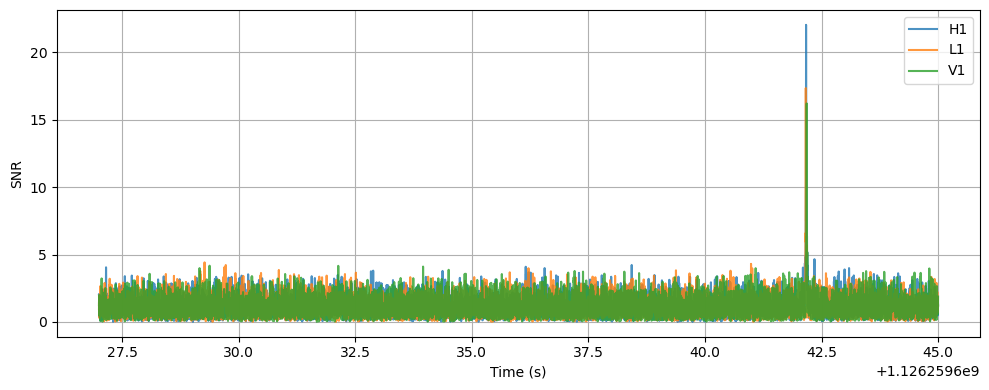

In [14]:
mass_range = np.arange(20, 50, 1)

def preprocess_strain(channel_name, filename='PE.gwf', delta_t=1.0/1024, hp_cut=20.0):
    strain = frame.read_frame(filename, channel_name)
    strain = highpass(strain, hp_cut)
    strain = resample_to_delta_t(strain, delta_t)
    return strain

strain_H1 = preprocess_strain('H1:FAKE_STRAIN')
strain_L1 = preprocess_strain('L1:FAKE_STRAIN')
strain_V1 = preprocess_strain('V1:FAKE_STRAIN')

print("Strain data read from GWF file.")

def compute_psd(strain, seg_length=4, flow=20.0):
    psd = strain.psd(seg_length)
    psd = interpolate(psd, strain.delta_f)
    psd = inverse_spectrum_truncation(psd, int(seg_length * strain.sample_rate), low_frequency_cutoff=flow)
    return psd

psd_H1 = compute_psd(strain_H1)
psd_L1 = compute_psd(strain_L1)
psd_V1 = compute_psd(strain_V1)

# Matched filtering
def run_matched_filter(strain, psd, mass_range, detector_name):
    max_snr = 0
    best_m1, best_m2 = None, None
    best_snr_series = None

    for m1 in mass_range:
        for m2 in mass_range:
            if m2 > m1:
                continue  
            try:
                hp, _ = get_td_waveform(
                                        approximant="SEOBNRv4_opt",
                                        mass1=m1, mass2=m2,
                                        delta_t=strain.delta_t, f_lower=30
                                        )
                hp.resize(len(strain))
                snr = matched_filter(hp, strain, psd=psd, low_frequency_cutoff=20)
                snr = snr.crop(8, 4)
                peak = abs(snr).numpy().argmax()
                snrp = abs(snr[peak])

                if snrp > max_snr:
                    max_snr = snrp
                    best_m1, best_m2 = m1, m2
                    best_snr_series = snr
            except Exception as e:
                continue 

    peak_time = best_snr_series.sample_times[np.argmax(abs(best_snr_series))]
    print(f"[{detector_name}] Max SNR: {max_snr:.2f} at {peak_time}s for masses: m1={best_m1}, m2={best_m2}")
    return best_snr_series, detector_name
    
print("Running matched filter...")

snr_H1, _ = run_matched_filter(strain_H1, psd_H1, mass_range, "H1")
snr_L1, _ = run_matched_filter(strain_L1, psd_L1, mass_range, "L1")
snr_V1, _ = run_matched_filter(strain_V1, psd_V1, mass_range, "V1")

plt.figure(figsize=[10, 4])
plt.plot(snr_H1.sample_times, abs(snr_H1), label='H1', alpha=0.8)
plt.plot(snr_L1.sample_times, abs(snr_L1), label='L1', alpha=0.8)
plt.plot(snr_V1.sample_times, abs(snr_V1), label='V1', alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("SNR")
#plt.title("Matched Filter SNR (Best Templates)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

